In [2]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import data_setup
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
image_path = 'data/pizza_steak_sushi'

In [4]:
train_dir = image_path + "/train"
test_dir = image_path + "/test"
print(train_dir)
print(test_dir)

data/pizza_steak_sushi/train
data/pizza_steak_sushi/test


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [24]:
BATCH_SIZE_TOTAL = 32
MINI_BATCH = 16

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=MINI_BATCH
)

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image,label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

Visualize image

In [20]:
from einops import rearrange

In [73]:
test_image_arrange_1 = rearrange(image, "c (h p1) (w p2) -> (h w) (p1 p2 c)", p1=16, p2=16)

test_image_visualize = rearrange(image, "c (h p1) (w p2) -> (h w) p1 p2 c", p1=16,p2=16)

In [78]:
test_image_visualize.shape
n_patch, img_h, img_w, _ = test_image_visualize.shape

In [74]:
PATCH_SIZE = 16
NUM_PATCHES = IMG_SIZE / PATCH_SIZE

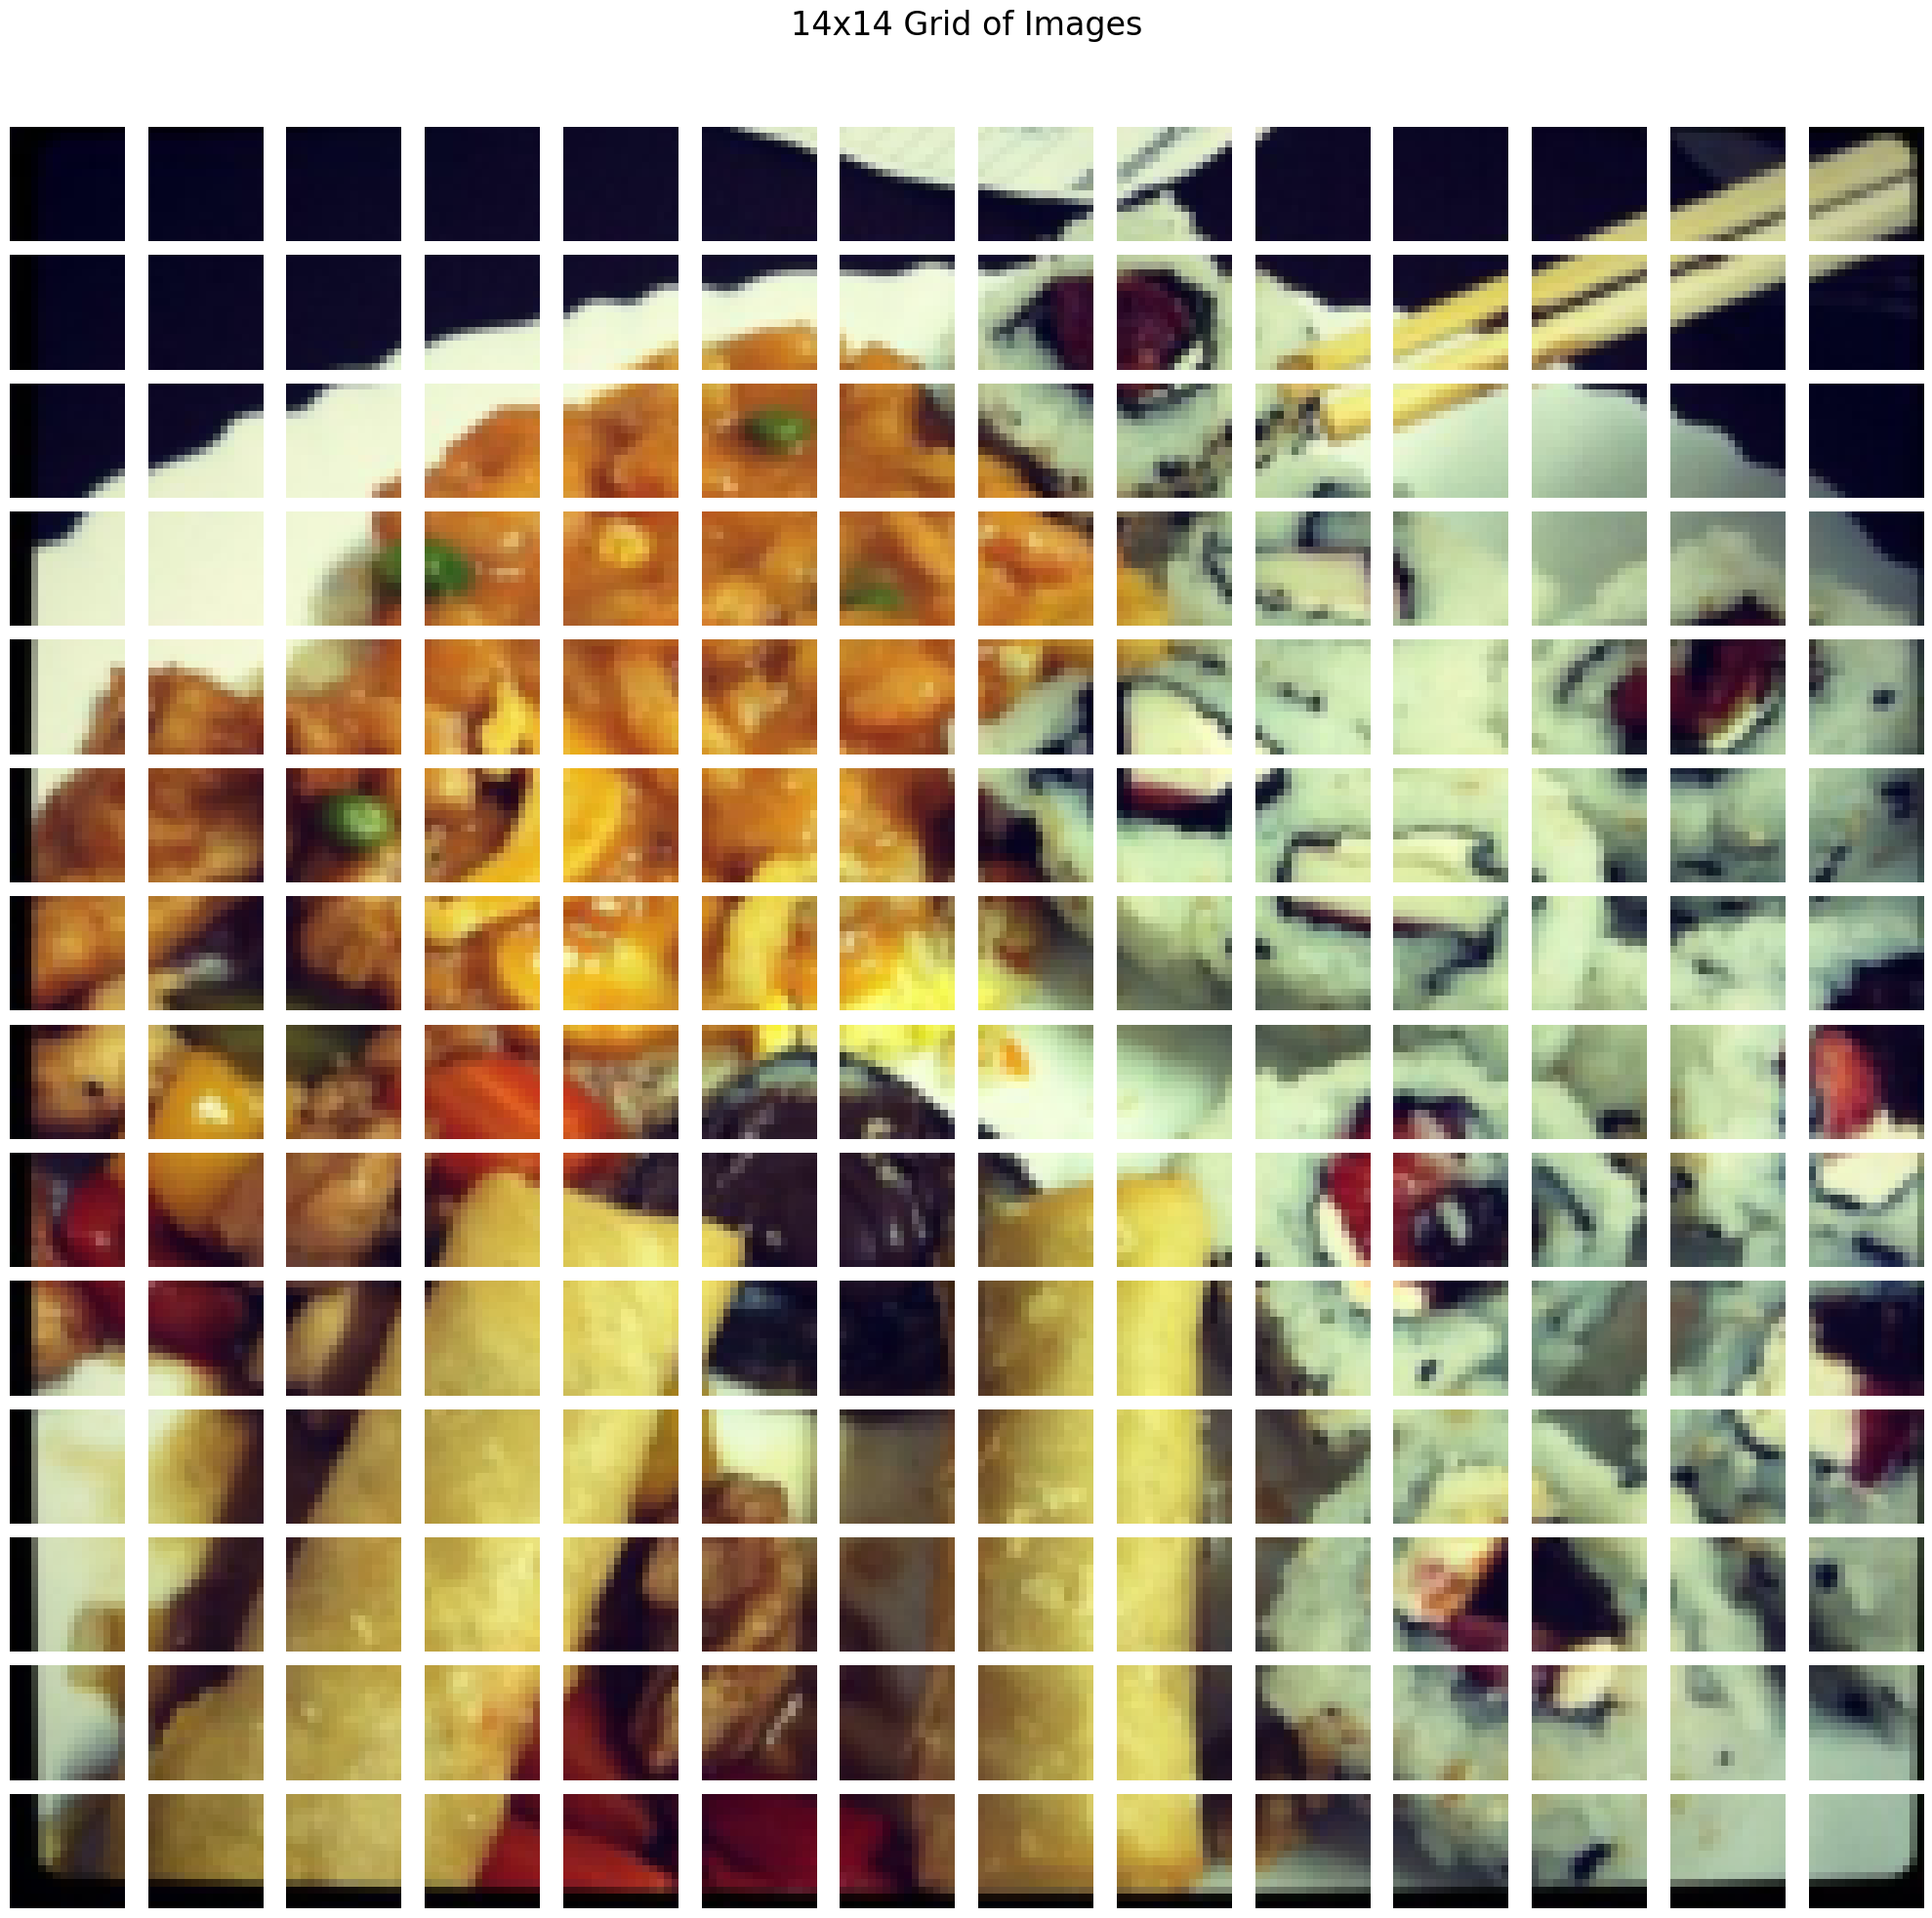

In [85]:

fig, axes = plt.subplots(14, 14, figsize=(20, 20))

# Loop through the rows and columns to plot the images
for i in range(14):
    for j in range(14):
        img_index = i * 14 + j  # Calculate the index for the batch of images
        img = test_image_visualize[img_index].numpy()  # Convert to numpy array for plotting
        axes[i, j].imshow(img)  # Display the image
        axes[i, j].axis('off')  # Turn off axis labels

# Set the title for the entire grid of images
plt.suptitle("14x14 Grid of Images", fontsize=24)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.subplots_adjust(top=0.92)  # Adjust the top to make space for the title
plt.show()

Training

In [23]:
torch.random.manual_seed(1337)

In [18]:
torch.__version__

'2.4.0'

In [12]:
from ViT import ViT
model = ViT()

In [22]:
EPOCH = 10
GRAD_ACCUM_STEP = BATCH_SIZE_TOTAL // MINI_BATCH
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-3)


In [25]:
def inf_train_gen():
    while True:
        for images, targets in train_dataloader:
            yield images, targets

In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

In [ ]:
def training():
    for epoch in range(EPOCH):
        
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        # Create a new instance of the generator for each epoch
        train_gen = inf_train_gen() 
        
        epoch_bar = tqdm(total=len(train_dataloader.dataset), desc=f"Epoch {epoch + 1}/{EPOCH}", position=0, leave=True)
        while total_samples < len(train_dataloader.dataset):
            optimizer.zero_grad(set_to_none=True)
            
            for micro_step in range(GRAD_ACCUM_STEP):
                input, label = next(train_gen)
                input, label = input.to(device), label.to(device)

                outputs = model(input)
                loss = loss_fn(outputs, label)
                loss = loss / GRAD_ACCUM_STEP
                loss.backward()
                
                # Accumulate running loss and accuracy
                running_loss += loss.item() * GRAD_ACCUM_STEP * input.size(0)
                correct = calculate_accuracy(outputs, label) 
                running_corrects += correct
                total_samples += input.size(0)

                
                # Update tqdm description with running metrics
                epoch_bar.set_postfix({
                    "loss": running_loss / total_samples if total_samples > 0 else 0,
                    "accuracy": running_corrects / total_samples if total_samples > 0 else 0
                })
                # Increment the progress bar
                epoch_bar.update(input.size(0))
                
                if total_samples >= len(train_dataloader.dataset):
                    break
                
            optimizer.step()
        epoch_bar.close()
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:  # Using validation set for accuracy
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if total >= 6000:
                    break
        
        accuracy = correct / total
        print(f'Epoch {epoch + 1}/{EPOCH}, Loss: {running_loss / total_samples:.4f}, Accuracy: {accuracy:.4f}')